
# 9. 直方图均衡与匹配

## 直方图均衡化
### 理论
  - 在整个亮度范围内获得具有均匀分布的亮度级别的图像
  - 在图像对比度低的时候可以使用


理论计算

- 对于离散值，我们得到 probabilities 和 summations，而不是 p.d.fs 和积分

$$
p_r(r_k)=n_k/(MN),\quad k=0,1,...,L-1
$$

- 其中 $MN$ 是图像中的总像素数，$n_k$ 是具有灰度值为 $r_k$ 的像素数，$L$ 是总灰度值数，$k$ 是 0 到 255 中的数

所以
$$
s_k=T(r_k)=(L-1)\sum\limits_{j=0}^k p_r(r_j)=\frac{L-1}{MN}\sum\limits_{j=0}^k n_j\\
k=0,1,...,L-1
$$
这种变换称为直方图均衡。然而，在实际应用中，获得完全均匀分布（离散版本）是很少见的。


和灰度值有关的变量有 2 个
  - $k$ 和 $r_k$


![](assets/histgram_equal.png)



![](images/直方图均衡.png)



目的
- 直方图均衡化是将原图像通过某种变换，得到一幅灰度直方图为均匀分布的新图像的方法。
- 直方图均衡化方法的基本思想是对在图像中像素个数多的灰度级进行展宽，而对像素个数少的灰度级进行缩减。从而达到清晰图像的目的。


### 代码实现
函数：`cv2.equalizeHist(img)`
- 参数1： 待均衡化图像

步骤
- 统计直方图中每个灰度级出现的次数
- 计算累计归一化直方图
- 重新计算像素点的像素值


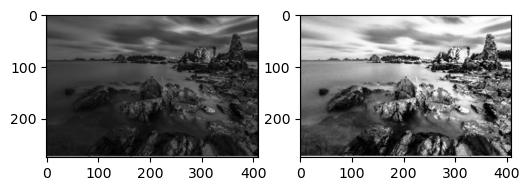

In [2]:
# 灰度直方图均衡化
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

#直接读为灰度图像
img = cv2.imread('./images2/dark.png', 0)
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#调用cv2.equalizeHist函数进行直方图均衡化
img_equal = cv2.equalizeHist(img)

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_equal, cv2.COLOR_BGR2RGB))
plt.show()

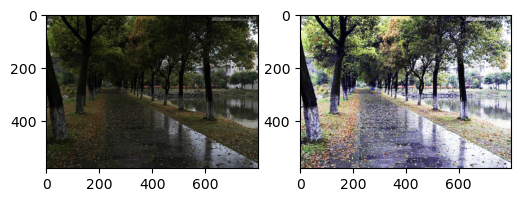

In [4]:
# 彩色直方图均衡化
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

img = cv2.imread("./images2/dark1.jpg")
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 彩色图像均衡化,需要分解通道 对每一个通道均衡化
(b, g, r) = cv2.split(img)
bH = cv2.equalizeHist(b)
gH = cv2.equalizeHist(g)
rH = cv2.equalizeHist(r)
# 合并每一个通道
result = cv2.merge((bH, gH, rH))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.show()

## 直方图匹配 Histogram Matching

直方图匹配（Histogram Matching）是一种图像处理技术，旨在调整一幅图像的直方图，使其与目标图像的直方图尽可能相匹配。它的主要作用是使两幅图像的视觉效果趋于一致。直方图匹配在图像增强、色彩均匀化等方面有广泛的应用。





在 OpenCV 中，虽然没有直接用于直方图匹配的内置函数，但我们可以通过计算图像的累积分布函数 (CDF) 来实现这一功能。

### 实现步骤
1. **计算源图像的直方图**。
2. **计算源图像的累积分布函数 (CDF)**。
3. **计算目标图像的直方图及其 CDF**。
4. **找到与目标图像 CDF 匹配的映射关系**。
5. **对源图像进行像素值映射**。


### 代码实现

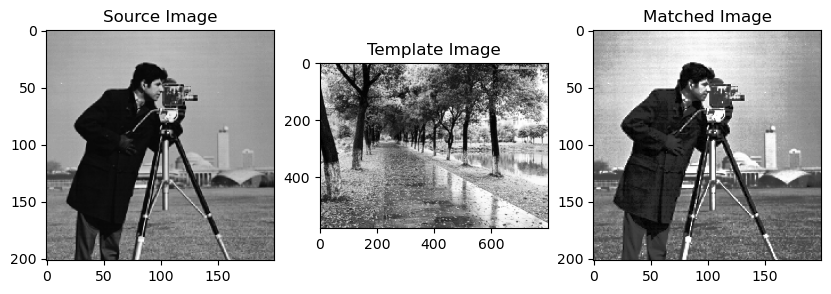

In [8]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_cdf(hist):
    # 计算直方图的累积分布函数（CDF）
    cdf = hist.cumsum()
    cdf_normalized = cdf / cdf.max()  # 归一化到 [0, 1] 范围
    return cdf_normalized

def histogram_matching(source, template):
    # 计算源图像和目标图像的直方图（灰度图像）
    source_hist, bins = np.histogram(source.flatten(), 256, [0, 256])
    template_hist, bins = np.histogram(template.flatten(), 256, [0, 256])
    
    # 计算CDF
    source_cdf = calculate_cdf(source_hist)
    template_cdf = calculate_cdf(template_hist)
    
    # 构建映射表
    lookup_table = np.zeros(256)
    template_idx = 0
    
    for source_idx in range(256):
        while template_idx < 255 and template_cdf[template_idx] < source_cdf[source_idx]:
            template_idx += 1
        lookup_table[source_idx] = template_idx
    
    # 应用映射表
    matched_image = cv2.LUT(source, lookup_table.astype(np.uint8))
    
    return matched_image

# 读取图像（灰度图像）
source_image = cv2.imread('images/person.png', cv2.IMREAD_GRAYSCALE)
# template_image = cv2.imread('images/da.png', cv2.IMREAD_GRAYSCALE)

template_image = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)

# 执行直方图匹配
matched_image = histogram_matching(source_image, template_image)

# 显示结果
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(source_image, cmap='gray')
plt.title('Source Image')

plt.subplot(1, 3, 2)
plt.imshow(template_image, cmap='gray')
plt.title('Template Image')

plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap='gray')
plt.title('Matched Image')

plt.show()

代码说明
1. **计算直方图**：我们使用 `np.histogram()` 计算源图像和目标图像的直方图，范围是 `[0, 256]`，因为图像的像素值在 0 到 255 之间。
2. **计算 CDF**：我们通过累加直方图计算累积分布函数 (CDF) 并归一化到 `[0, 1]`。
3. **建立映射关系**：根据源图像和目标图像的 CDF 建立像素值的映射关系。
4. **应用映射关系**：我们使用 `cv2.LUT()` 函数，根据映射表将源图像的像素值转换为与目标图像匹配的像素值。

### 示例：
1. **Source Image**：希望调整的图像。
2. **Template Image**：希望匹配其直方图的目标图像。
3. **Matched Image**：应用直方图匹配后的结果图像。

### 总结：
直方图匹配是一种将图像调整为与另一张图像有相似视觉效果的技术。通过计算两个图像的累积分布函数，并对源图像的像素进行映射，我们能够实现这个功能。